In [13]:
import os
os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openai
openai.api_key = os.environ['OPENAI_API_KEY']
openai.api_base = os.environ.get("OPENAI_API_BASE", "https://api.openai.com/v1")
from data.serialize import SerializerSettings
from models.utils import grid_iter
from models.promptcast import get_promptcast_predictions_data
from models.darts import get_arima_predictions_data
from models.llmtime import get_llmtime_predictions_data
from data.small_context import get_datasets
from models.validation_likelihood_tuning import get_autotuned_predictions_data
from sklearn.metrics import mean_squared_error
import time

%load_ext autoreload
%autoreload 2

def plot_preds(train, test, pred_dict, model_name, show_samples=False):
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    error_mse = mean_squared_error(
                y_true = test,
                y_pred = pred
            )

    print(f"Test error (MSE): {error_mse}")
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

gpt3_hypers = dict(
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)


promptcast_hypers = dict(
    temp=0.7,
    settings=SerializerSettings(base=10, prec=0, signed=True, 
                                time_sep=', ',
                                bit_sep='',
                                plus_sign='',
                                minus_sign='-',
                                half_bin_correction=False,
                                decimal_point='')
)

arima_hypers = dict(p=[12,30], d=[1,2], q=[0])

model_hypers = {
    'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
    'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
    'LLMTime GPT-3': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
    'PromptCast GPT-3': {'model': 'gpt-3.5-turbo-instruct', **promptcast_hypers},
    'ARIMA': arima_hypers,
    
}

model_predict_fns = {
    'LLMTime GPT-3': get_llmtime_predictions_data,
    'LLMTime GPT-4': get_llmtime_predictions_data,
    'PromptCast GPT-3': get_promptcast_predictions_data,
    'ARIMA': get_arima_predictions_data,
}

model_names = list(model_predict_fns.keys())

In [41]:
datasets = get_datasets()
ds_name = 'AirPassengersDataset'

data = datasets[ds_name]
print(len(data))
train, test = data 
print('train\n')
print(len(train))
print(train)
print('test\n')
print(len(test))
print(test)


2
train

115
Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1958-03-01    362.0
1958-04-01    348.0
1958-05-01    363.0
1958-06-01    435.0
1958-07-01    491.0
Freq: MS, Name: #Passengers, Length: 115, dtype: float64
test

29
Month
1958-08-01    505.0
1958-09-01    404.0
1958-10-01    359.0
1958-11-01    310.0
1958-12-01    337.0
1959-01-01    360.0
1959-02-01    342.0
1959-03-01    406.0
1959-04-01    396.0
1959-05-01    420.0
1959-06-01    472.0
1959-07-01    548.0
1959-08-01    559.0
1959-09-01    463.0
1959-10-01    407.0
1959-11-01    362.0
1959-12-01    405.0
1960-01-01    417.0
1960-02-01    391.0
1960-03-01    419.0
1960-04-01    461.0
1960-05-01    472.0
1960-06-01    535.0
1960-07-01    622.0
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Freq: MS, Name: #Passengers, dtype: float64


In [43]:
path = 'datasets/synthetic/sine.npy'
data = np.load(path)
data = pd.Series(data[0,:])
n = len(data)
m = n*3//4
train = data[0:m]
test = data[m:]# or change to your own data
print(train)
print(test)

0      0.000000
1      0.342020
2      0.642788
3      0.866025
4      0.984808
         ...   
145    0.342020
146    0.642788
147    0.866025
148    0.984808
149    0.984808
Length: 150, dtype: float64
150    8.660254e-01
151    6.427876e-01
152    3.420201e-01
153   -1.470814e-15
154   -3.420201e-01
155   -6.427876e-01
156   -8.660254e-01
157   -9.848078e-01
158   -9.848078e-01
159   -8.660254e-01
160   -6.427876e-01
161   -3.420201e-01
162   -2.204364e-15
163    3.420201e-01
164    6.427876e-01
165    8.660254e-01
166    9.848078e-01
167    9.848078e-01
168    8.660254e-01
169    6.427876e-01
170    3.420201e-01
171    5.879543e-15
172   -3.420201e-01
173   -6.427876e-01
174   -8.660254e-01
175   -9.848078e-01
176   -9.848078e-01
177   -8.660254e-01
178   -6.427876e-01
179   -3.420201e-01
180   -2.449294e-15
181    3.420201e-01
182    6.427876e-01
183    8.660254e-01
184    9.848078e-01
185    9.848078e-01
186    8.660254e-01
187    6.427876e-01
188    3.420201e-01
189   -9.809554e

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': True, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.62s/it]


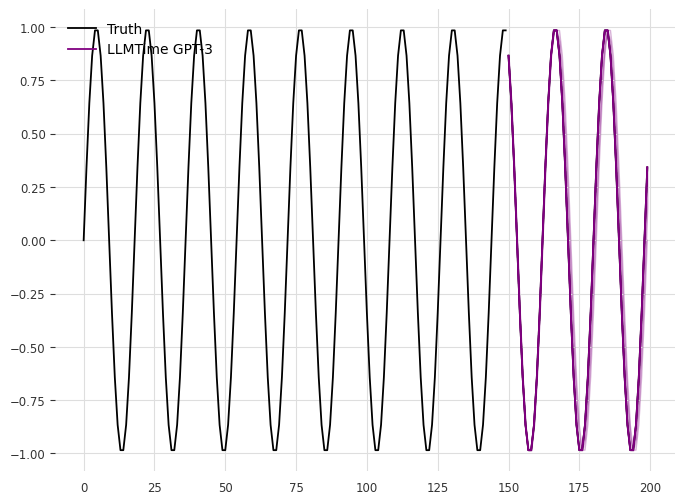

In [44]:
#basic = True
out = {}
model = 'LLMTime GPT-3'

model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

In [54]:
path = 'datasets/synthetic/sine.npy'
data = np.load(path)
data = pd.Series(data[0,:])
n = len(data)
m = n*1//2
train = data[0:m]
test = data[m:]# or change to your own data
print(train)
print(test)

0     0.000000e+00
1     3.420201e-01
2     6.427876e-01
3     8.660254e-01
4     9.848078e-01
          ...     
95    9.848078e-01
96    8.660254e-01
97    6.427876e-01
98    3.420201e-01
99   -2.205602e-15
Length: 100, dtype: float64
100   -3.420201e-01
101   -6.427876e-01
102   -8.660254e-01
103   -9.848078e-01
104   -9.848078e-01
           ...     
195   -8.660254e-01
196   -6.427876e-01
197   -3.420201e-01
198    4.411204e-15
199    3.420201e-01
Length: 100, dtype: float64


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': True, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.70s/it]


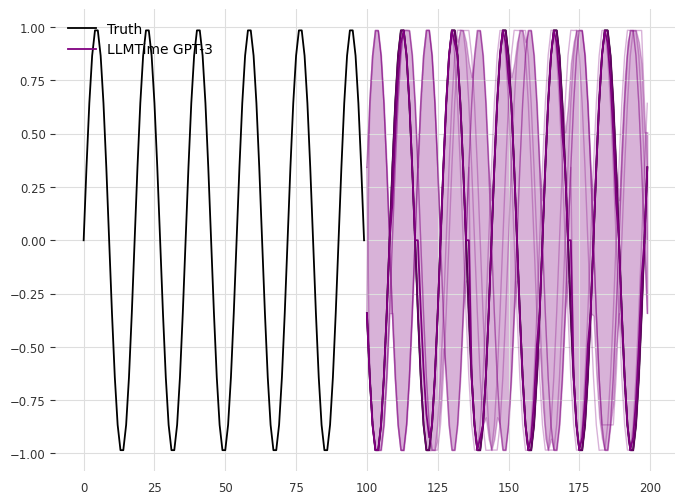

In [55]:
#Baisc = True
out = {}
model = 'LLMTime GPT-3'

model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.68s/it]


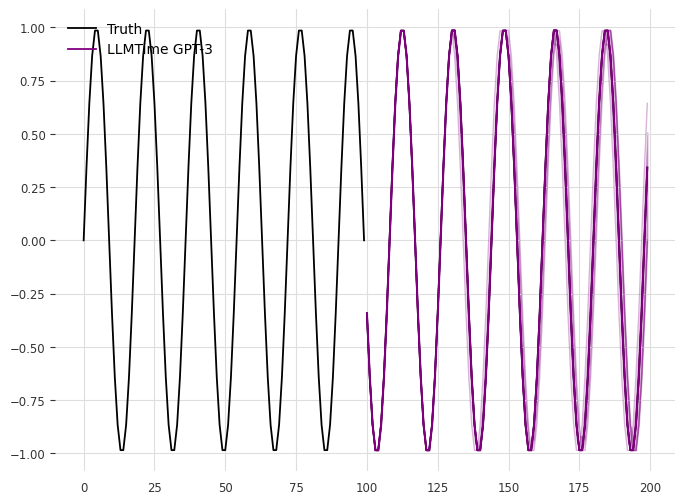

In [57]:
#Baisc = False
out = {}
model = 'LLMTime GPT-3'

model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

In [60]:
path = 'datasets/synthetic/sine.npy'
data = np.load(path)
data = pd.Series(data[0,:])
n = len(data)
m = n*1//4
train = data[0:m]
test = data[m:]

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.29s/it]

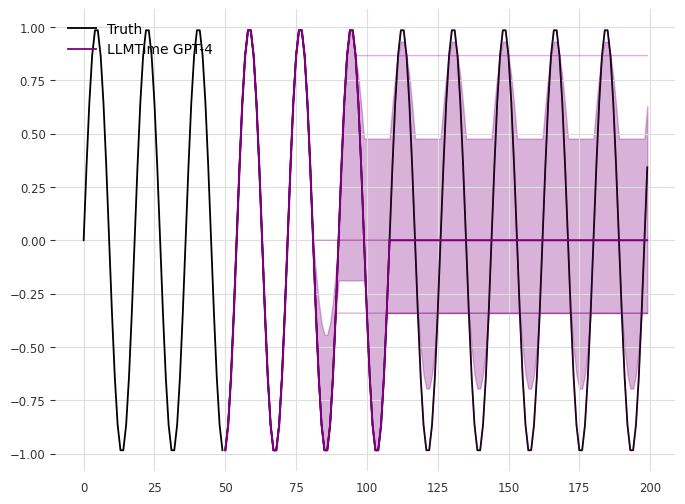

In [62]:
#Baisc = False
out = {}
model = 'LLMTime GPT-4'

model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=True, parallel=False)
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

In [45]:
path = 'datasets/synthetic/log.npy'
data = np.load(path)
data = pd.Series(data[0,:])
n = len(data)
m = n*3//4
train = data[0:m]
test = data[m:]
print(train)
print(test)

0     -2.302585
1     -2.258352
2     -2.215993
3     -2.175355
4     -2.136304
         ...   
145   -0.280006
146   -0.274040
147   -0.268109
148   -0.262214
149   -0.256352
Length: 150, dtype: float64
150   -0.250525
151   -0.244732
152   -0.238972
153   -0.233245
154   -0.227550
155   -0.221888
156   -0.216258
157   -0.210659
158   -0.205091
159   -0.199555
160   -0.194048
161   -0.188572
162   -0.183126
163   -0.177709
164   -0.172321
165   -0.166963
166   -0.161633
167   -0.156331
168   -0.151057
169   -0.145810
170   -0.140591
171   -0.135400
172   -0.130235
173   -0.125096
174   -0.119984
175   -0.114898
176   -0.109837
177   -0.104802
178   -0.099793
179   -0.094808
180   -0.089848
181   -0.084912
182   -0.080001
183   -0.075114
184   -0.070250
185   -0.065410
186   -0.060593
187   -0.055800
188   -0.051029
189   -0.046281
190   -0.041555
191   -0.036852
192   -0.032170
193   -0.027511
194   -0.022873
195   -0.018256
196   -0.013661
197   -0.009086
198   -0.004533
199    0.000

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.07s/it]

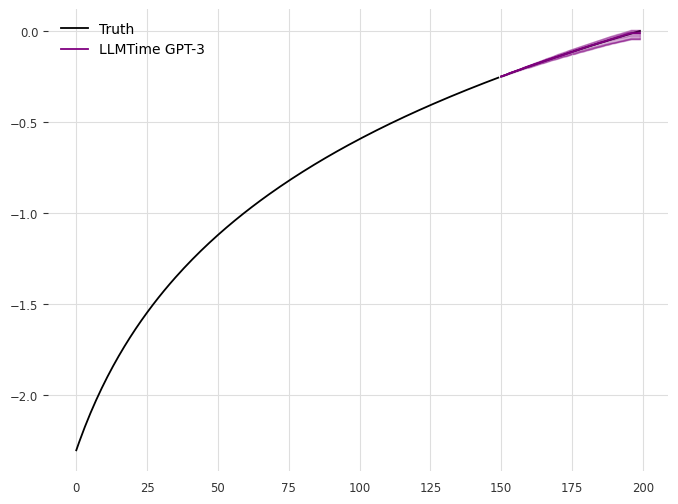

In [48]:
out = {}
model = 'LLMTime GPT-3'

model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=True, parallel=False)
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

In [67]:
path = 'datasets/synthetic/gaussian_wave.npy'
data = np.load(path)
data = pd.Series(data[0,:])
n = len(data)
m = n*3//4
train = data[0:m]
test = data[m:]

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.86s/it]


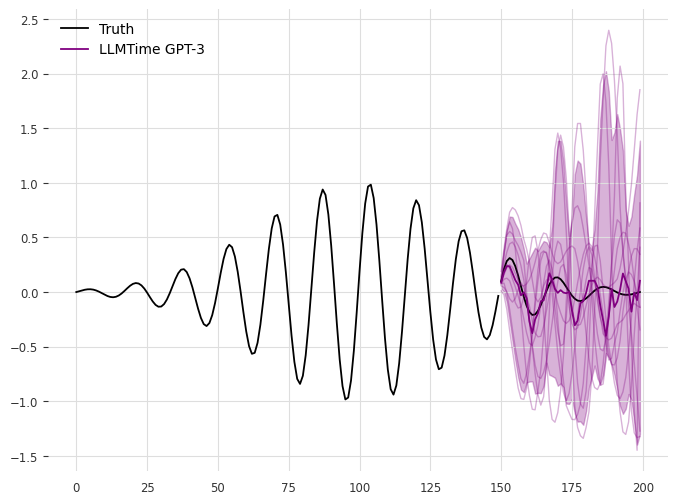

In [51]:
#basic = False
out = {}
model = 'LLMTime GPT-3'

model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=True, parallel=False)
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': True, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.72s/it]


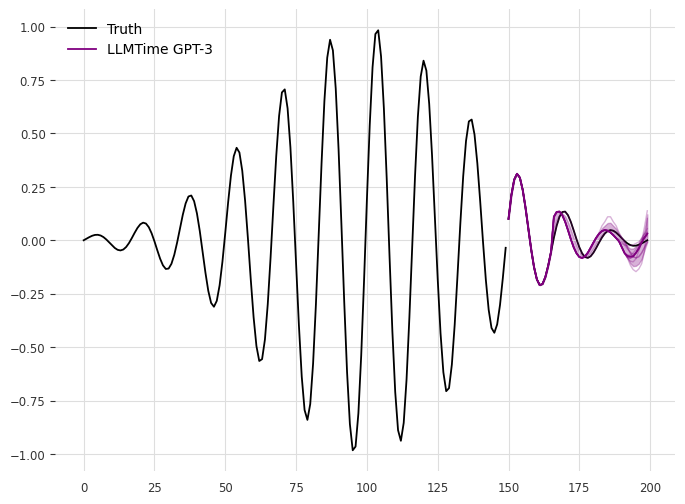

In [53]:
#basic = True
out = {}
model = 'LLMTime GPT-3'

model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=True, parallel=False)
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.45s/it]


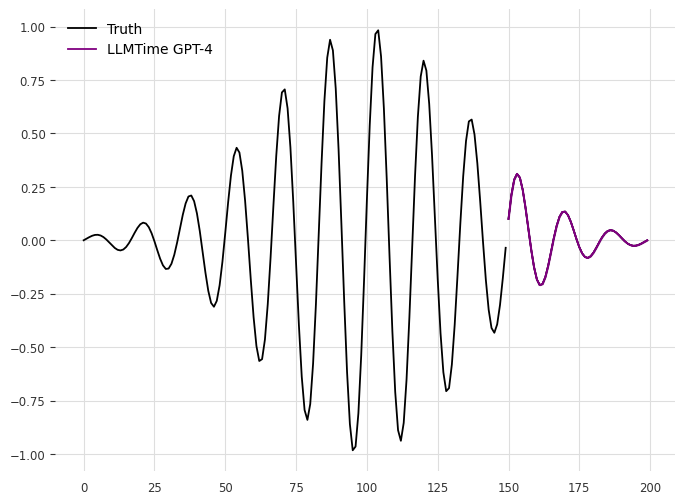

In [68]:
out = {}
model = 'LLMTime GPT-4'

model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=True, parallel=False)
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

In [28]:
path = 'datasets/synthetic/gaussian_wave.npy'
data = np.load(path)
data = pd.Series(data[0,:])
n = len(data)
m = n//4
train = data[2*m:3*m]
print(train)
test = data.loc[data.index.isin(np.r_[0:m,3*m:4*m])]

100    0.188293
101    0.537735
102    0.809744
103    0.965421
104    0.982935
105    0.860656
106    0.617261
107    0.288834
108   -0.076584
109   -0.426167
110   -0.710094
111   -0.888793
112   -0.938558
113   -0.854745
114   -0.652079
115   -0.362118
116   -0.028280
117    0.300757
118    0.578275
119    0.766255
120    0.840660
121    0.794508
122    0.638354
123    0.398183
124    0.111110
125   -0.180395
126   -0.434856
127   -0.617759
128   -0.706260
129   -0.691994
130   -0.581656
131   -0.395359
132   -0.163099
133    0.080041
134    0.299201
135    0.464759
136    0.556315
137    0.565134
138    0.494750
139    0.359760
140    0.183075
141   -0.007872
142   -0.185338
143   -0.325276
144   -0.410545
145   -0.432911
146   -0.393624
147   -0.302587
148   -0.176325
149   -0.035145
dtype: float64


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.03s/it]

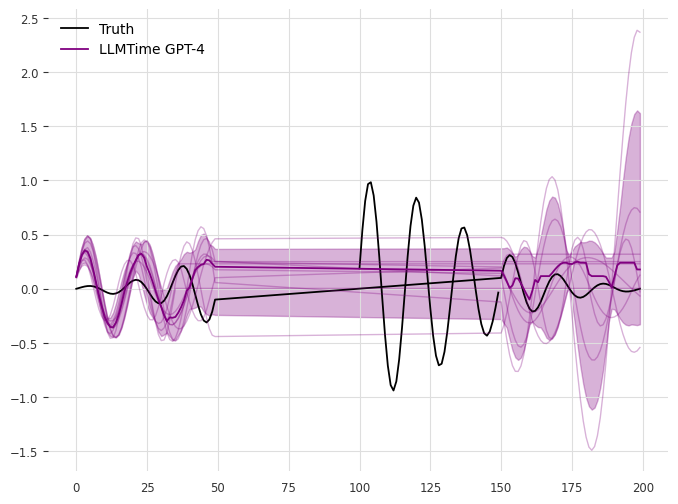

In [87]:
out = {}
model = 'LLMTime GPT-4'

model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=True, parallel=False)
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

In [64]:
path = 'datasets/synthetic/square.npy'
data = np.load(path)
data = pd.Series(data[0,:])
n = len(data)
m = n*3//4
train = data[0:m]
test = data[m:]# or change to your own data


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.67s/it]


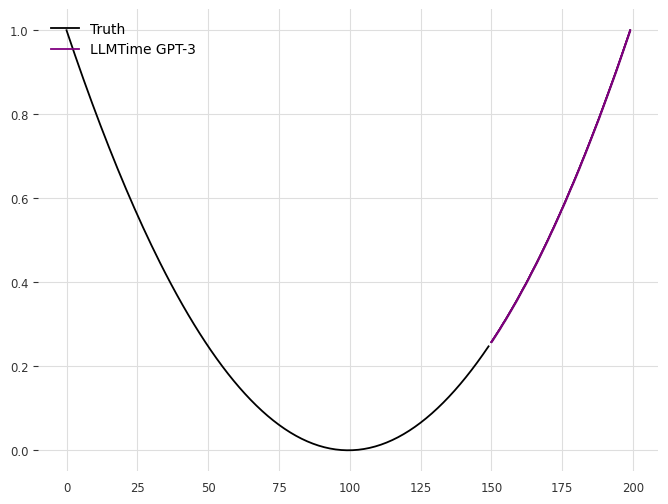

In [65]:
#basic = False
out = {}
model = 'LLMTime GPT-3'

model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=True, parallel=False)
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

In [89]:
path = 'datasets/synthetic/sigmoid.npy'
data = np.load(path)
data = pd.Series(data[0,:])
n = len(data)
m = n//2
train = data[0:m]
test = data[m:]# or change to your own data


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': True, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.17s/it]

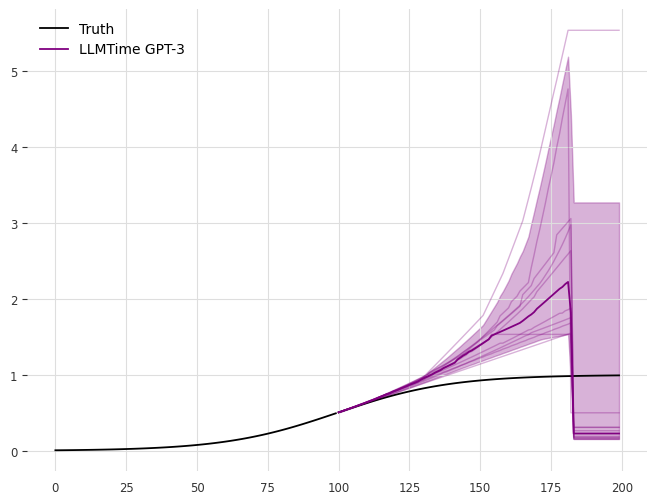

In [91]:
#basic = True
out = {}
model = 'LLMTime GPT-3'

model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=True, parallel=False)
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.25s/it]

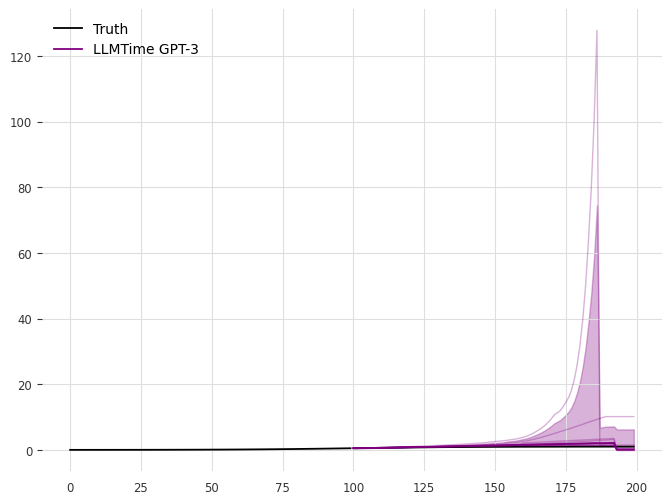

In [93]:
#basic = False
out = {}
model = 'LLMTime GPT-3'

model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=True, parallel=False)
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

Train length: 50, Val length: 50


Hyperparameter search:   0%|          | 0/4 [00:00<?, ?it/s]

/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood o

Hyper: defaultdict(<class 'dict'>, {'p': 12, 'd': 2, 'q': 0, 'dataset_name': 'AirPassengersDataset'}) 
	 Val NLL: -4.904006
Hyper: defaultdict(<class 'dict'>, {'p': 12, 'd': 1, 'q': 0, 'dataset_name': 'AirPassengersDataset'}) 
	 Val NLL: -3.089402


/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Hyper: defaultdict(<class 'dict'>, {'p': 30, 'd': 1, 'q': 0, 'dataset_name': 'AirPassengersDataset'}) 
	 Val NLL: -3.089280


/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Hyper: defaultdict(<class 'dict'>, {'p': 30, 'd': 2, 'q': 0, 'dataset_name': 'AirPassengersDataset'}) 
	 Val NLL: -4.904010
Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 30, 'd': 2, 'q': 0, 'dataset_name': 'AirPassengersDataset'}) 
 with NLL -4.904010


/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


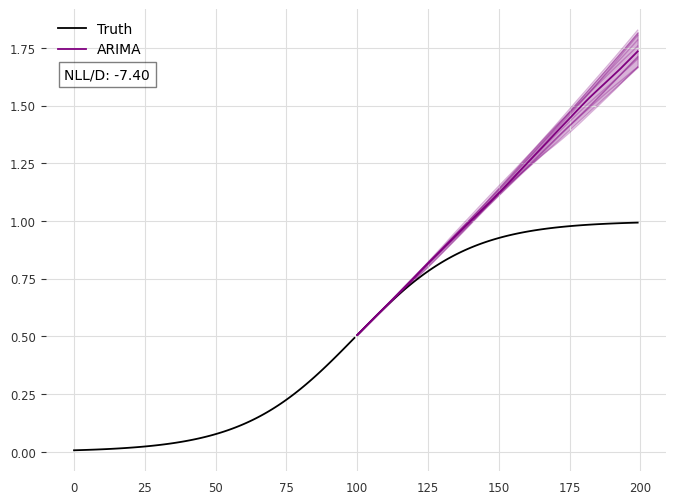

In [94]:
out = {}
model = 'ARIMA'

model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=True, parallel=False)
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:25<00:00, 25.01s/it]

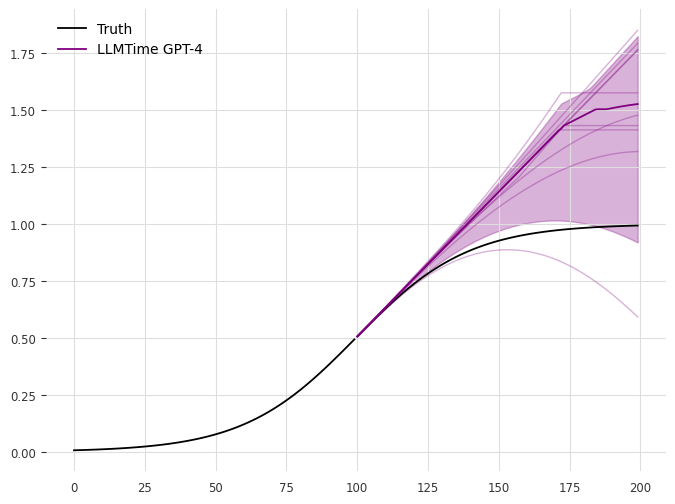

In [95]:
out = {}
model = 'LLMTime GPT-4'

model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=True, parallel=False)
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

In [97]:
path = 'datasets/synthetic/sigmoid.npy'
data = np.load(path)
data = pd.Series(data[0,:])
n = len(data)
m = n*2//3
train = data[0:m]
test = data[m:]# or change to your own data


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.87s/it]

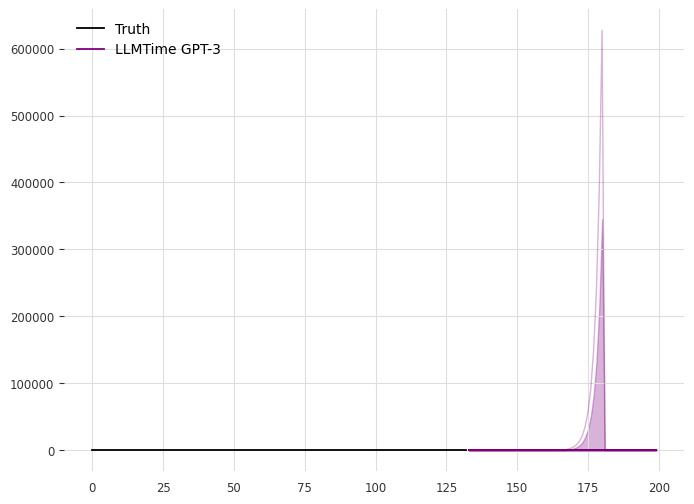

In [98]:
#basic = False
out = {}
model = 'LLMTime GPT-3'

model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=True, parallel=False)
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

Train length: 67, Val length: 66


Hyperparameter search:   0%|          | 0/4 [00:00<?, ?it/s]

/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Hyper: defaultdict(<class 'dict'>, {'p': 12, 'd': 2, 'q': 0, 'dataset_name': 'AirPassengersDataset'}) 
	 Val NLL: -6.720061
Hyper: defaultdict(<class 'dict'>, {'p': 12, 'd': 1, 'q': 0, 'dataset_name': 'AirPassengersDataset'}) 
	 Val NLL: -3.140380


/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as star

Hyper: defaultdict(<class 'dict'>, {'p': 30, 'd': 1, 'q': 0, 'dataset_name': 'AirPassengersDataset'}) 
	 Val NLL: -3.140362


/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Hyper: defaultdict(<class 'dict'>, {'p': 30, 'd': 2, 'q': 0, 'dataset_name': 'AirPassengersDataset'}) 
	 Val NLL: -6.720062
Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 30, 'd': 2, 'q': 0, 'dataset_name': 'AirPassengersDataset'}) 
 with NLL -6.720062


/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


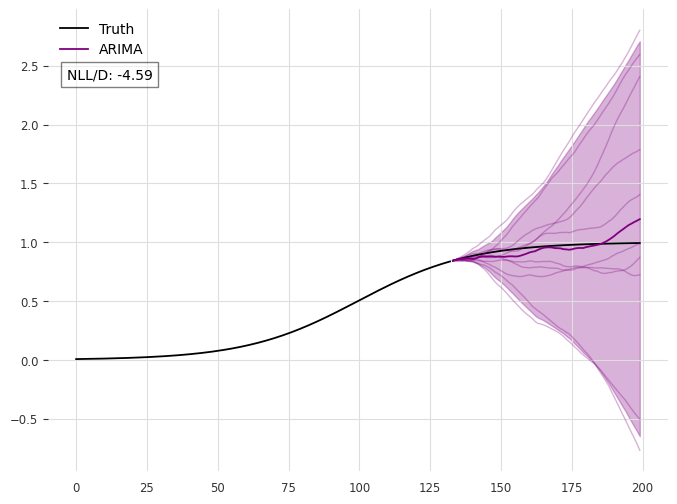

In [99]:
out = {}
model = 'ARIMA'

model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=True, parallel=False)
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.88s/it]

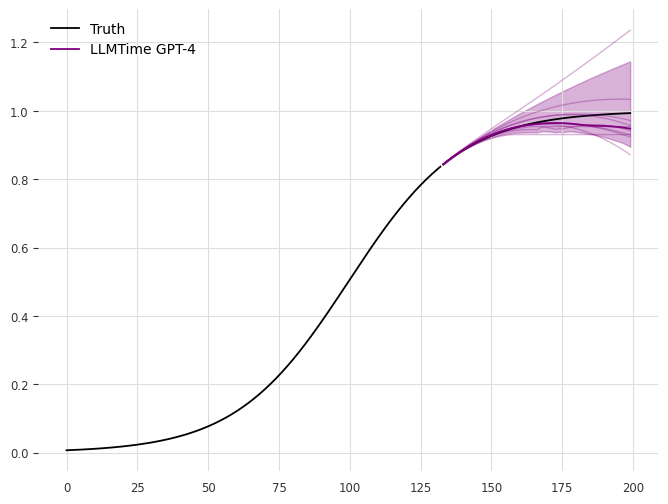

In [100]:
out = {}
model = 'LLMTime GPT-4'

model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=True, parallel=False)
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

0      1.000000
1      1.031075
2      1.061154
3      1.090239
4      1.118331
         ...   
128    3.419721
129    3.476330
130    3.533534
131    3.591308
132    3.649624
Length: 133, dtype: float64


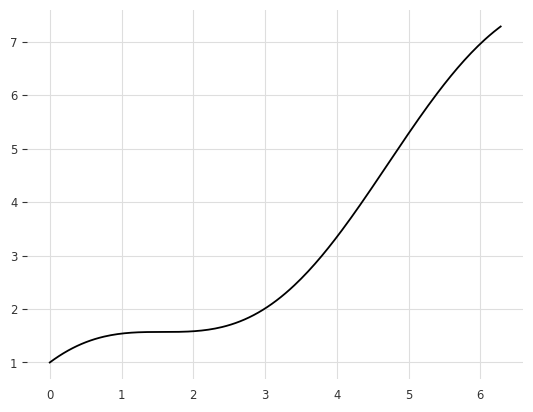

In [16]:
path = 'datasets/synthetic/sigmoid.npy'
n = 200
x = np.linspace(0,2*np.pi,n)
data = x + np.cos(x)
plt.plot(x,data)
data = np.array([data])
data = pd.Series(data[0,:])
m = n*2//3
train = data[0:m]
test = data[m:]# or change to your own data
print(train)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.27s/it]

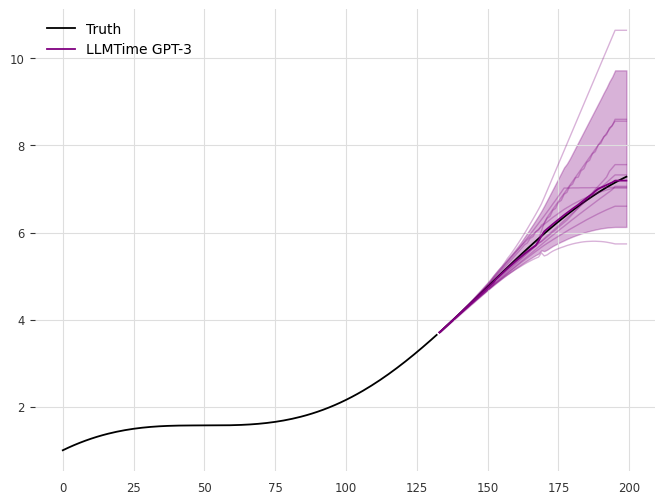

In [18]:
#basic = False
out = {}
model = 'LLMTime GPT-3'

hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=True, parallel=False)
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

[ 58  53 103  98 126  49  98   1  33  72  62  64  91  98 118 130  49  84
  89  89  37  96   7  87  82  87  62 127  19 121 110 131  72  93  82  49
   1 108   8  20   7  34   7   4]
0      1.000000
1           NaN
2      1.061154
3      1.090239
4           NaN
         ...   
128    3.419721
129    3.476330
130         NaN
131         NaN
132    3.649624
Length: 133, dtype: float64


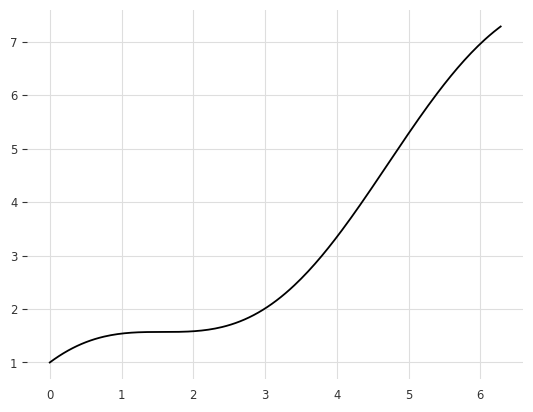

In [22]:
n = 200
x = np.linspace(0,2*np.pi,n)
data = x + np.cos(x)
plt.plot(x,data)
data = np.array([data])
data = pd.Series(data[0,:])
m = n*2//3
train = data[0:m]
miss = np.random.choice(m,m//3)
print(miss)
train[miss] = np.NAN
test = data[m:]# or change to your own data
print(train)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.72s/it]

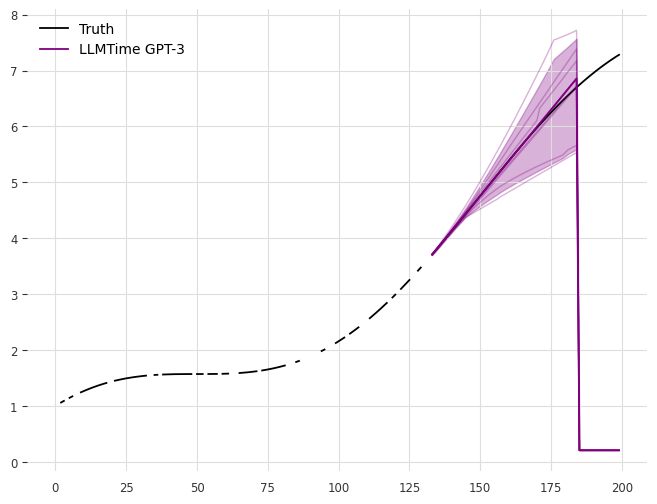

In [23]:
#basic = False
out = {}
model = 'LLMTime GPT-3'

hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=True, parallel=False)
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.54s/it]

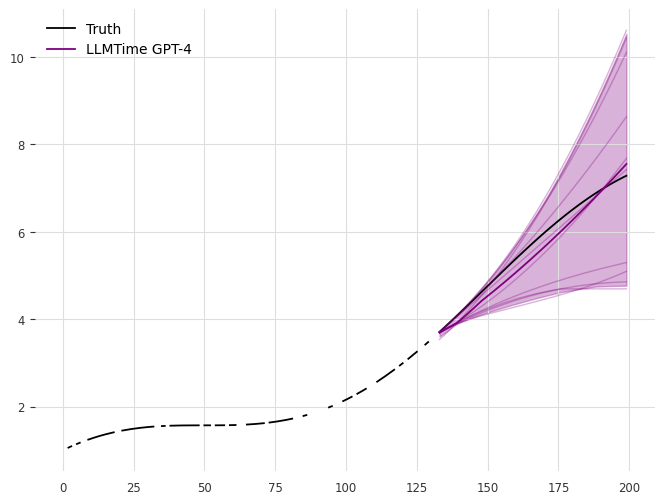

In [24]:
out = {}
model = 'LLMTime GPT-4'

hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=True, parallel=False)
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

[102  92  14 106  71  20 102 121  74  87 116  99 103 130 149  52   1  87
  37 129  20  57  21  88  48  58  14  50 107  54  63 130  50 134  20  72
  17 131  88  59  13   8  89  52 129  83  91 110   7  34]
0      1.000000
1           NaN
2      1.061154
3      1.090239
4      1.118331
         ...   
145    4.444414
146    4.507339
147    4.570367
148    4.633465
149         NaN
Length: 150, dtype: float64


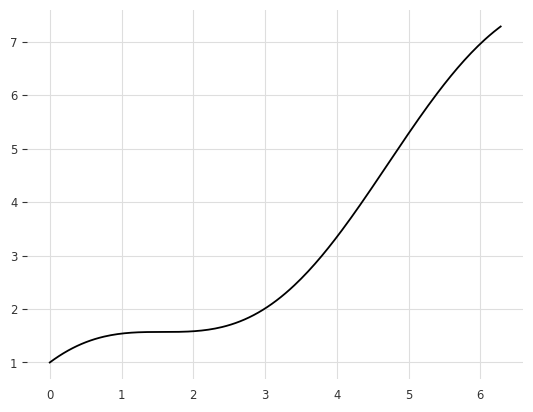

In [26]:
path = 'datasets/synthetic/sigmoid.npy'
n = 200
np.random.seed(42)
x = np.linspace(0,2*np.pi,n)
data = x + np.cos(x)
plt.plot(x,data)
data = np.array([data])
data = pd.Series(data[0,:])
m = n*3//4
train = data[0:m]
miss = np.random.choice(m,m//3)
print(miss)
train[miss] = np.NAN
test = data[m:]# or change to your own data
print(train)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.93s/it]

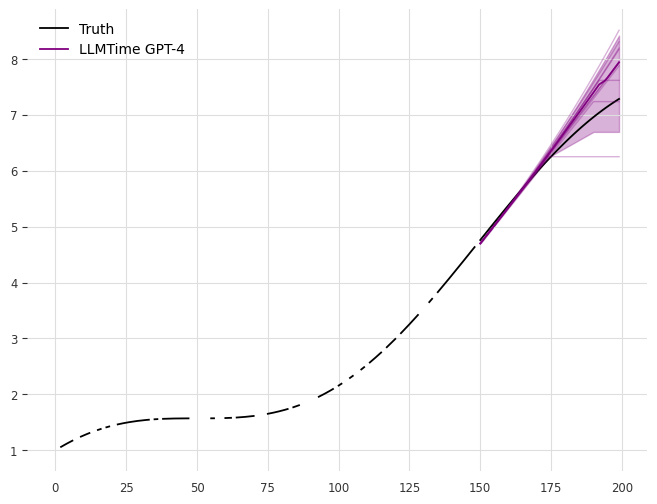

In [27]:
out = {}
model = 'LLMTime GPT-4'

hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=True, parallel=False)
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

'\nmiss = np.random.choice(m,m//3)\nprint(miss)\ntrain[miss] = np.NAN\ntest = data[m:]# or change to your own data\nprint(train)\n'

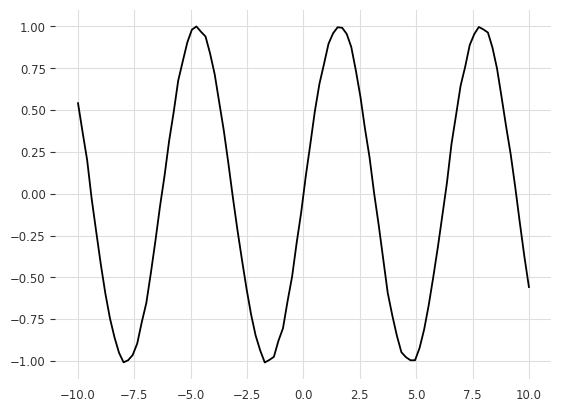

In [9]:
n = 100
x = np.linspace(-10,10,100);
series = np.sin(x) + 0.01*np.random.randn(100)
plt.plot(x,series)
#values = pd.DataFrame(series)
#data = series_to_supervised(values, n_in=10)

data = pd.Series(series)
m = n*3//4
train = data[0:m]
test = data[m:]
'''
miss = np.random.choice(m,m//3)
print(miss)
train[miss] = np.NAN
test = data[m:]# or change to your own data
print(train)
'''

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.15s/it]

 time: 3.279924154281616 s


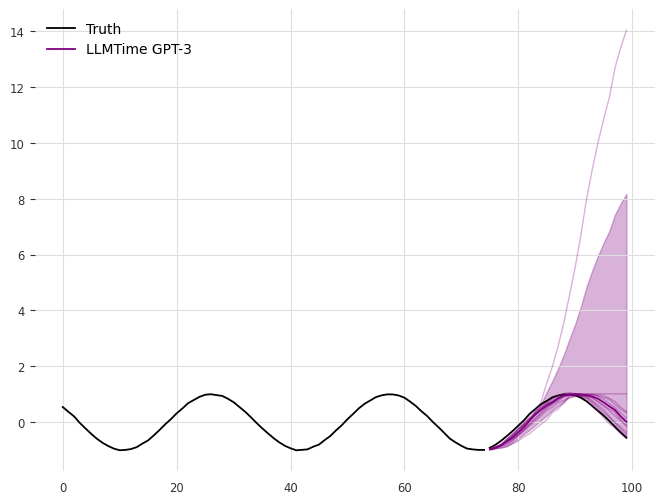

In [10]:
out = {}
model = 'LLMTime GPT-3'

hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
t0 = time.time()
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=True, parallel=False)
t1 = time.time()
print(' time: ' + str(t1 - t0) + ' s')
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

Train length: 50, Val length: 25


Hyperparameter search:   0%|          | 0/4 [00:00<?, ?it/s]

Hyper: defaultdict(<class 'dict'>, {'p': 12, 'd': 2, 'q': 0}) 
	 Val NLL: -2.249659


/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Hyper: defaultdict(<class 'dict'>, {'p': 12, 'd': 1, 'q': 0}) 
	 Val NLL: -2.561430


/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting aut

Hyper: defaultdict(<class 'dict'>, {'p': 30, 'd': 1, 'q': 0}) 
	 Val NLL: -2.827879


/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Hyper: defaultdict(<class 'dict'>, {'p': 30, 'd': 2, 'q': 0}) 
	 Val NLL: -1.707062
Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 30, 'd': 1, 'q': 0}) 
 with NLL -2.827879


/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


 time: 9.243983030319214 s


/home/yu/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


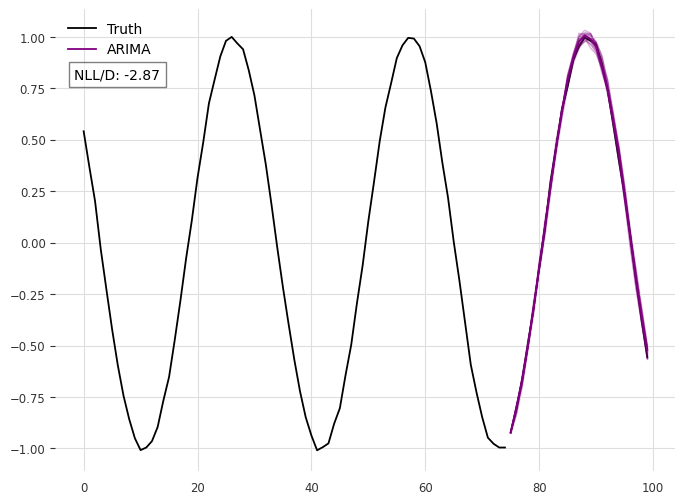

In [12]:
#basic = False
out = {}
model = 'ARIMA'

hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
t0 = time.time()
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=True, parallel=False)
t1 = time.time()
print(' time: ' + str(t1 - t0) + ' s')
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

Test error (MSE): 0.000276074526593515


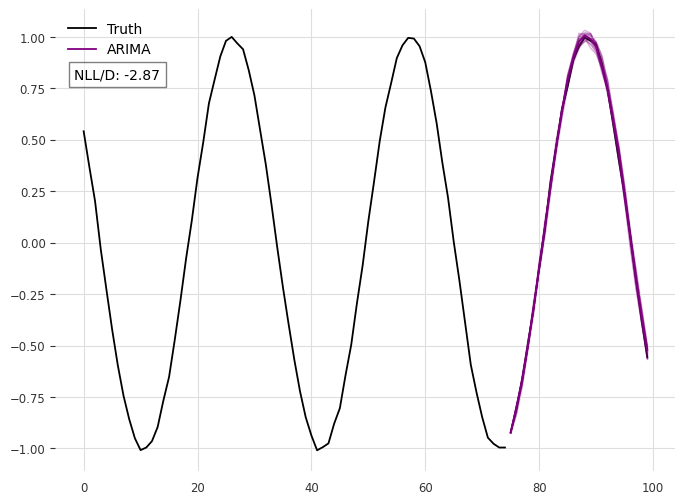

In [15]:
plot_preds(train, test, pred_dict, model, show_samples=True)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.65s/it]


Test error (MSE): 0.010942426257052202


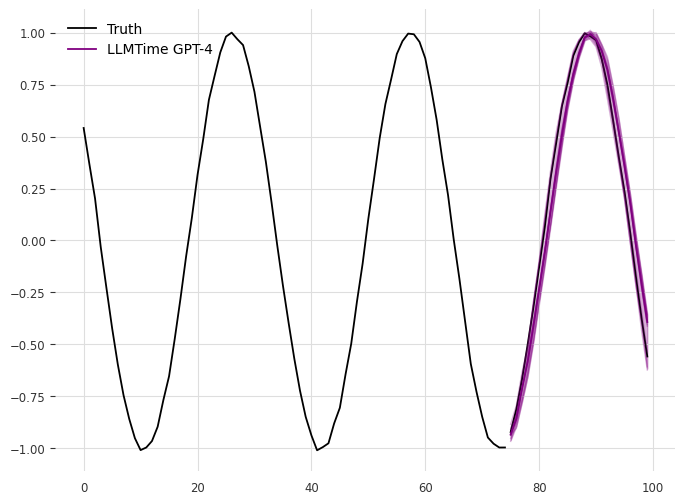

In [16]:
out = {}
model = 'LLMTime GPT-4'

hypers = list(grid_iter(model_hypers[model]))
num_samples = 10
t0 = time.time()
pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=True, parallel=False)
t1 = time.time()
print(' time: ' + str(t1 - t0) + ' s')
out[model] = pred_dict
plot_preds(train, test, pred_dict, model, show_samples=True)

In [17]:
print(' time: ' + str(t1 - t0) + ' s')

 time: 7.660340309143066 s


ValueError: Cannot load file containing pickled data when allow_pickle=False